# 3주차, 5일차 : 코드 암기하기
- ### Contents 
    1. Better performance with the tf.data API: https://www.tensorflow.org/guide/data_performance
    2. Time Series Forecasting: https://www.tensorflow.org/tutorials/structured_data/time_series
    3. Text Classification with an RNN: https://www.tensorflow.org/tutorials/text/text_classification_rnn
    4. Distributed training with Keras: https://www.tensorflow.org/tutorials/distribute/keras

## 1. Better performance with the tf.data API
### 개요 
GPU와 TPU는 하나의 학습 단계를 실행하는데 필요한 시간을 급격하게 줄일 수 있습니다. <br>
최대 성능을 위해서는 현재 단계가 종료되기 전에 다음 단계의 데이터를 운반하는 효율적인 입력 파이프라인이 필요합니다.<br>
`tf.data` API는 유연하고 효율적인 입력 파이프라인을 만드는데 도움이 됩니다. 

- 텐서플로 입력 파이프라인이 기본적으로 ETL 프로세스라는 것을 설명합니다.
- 고성능 텐서플로 입력 파이프라인을 설계하기 위해 권장하는 방법을 설명합니다. 
- 변환 순서에 따른 성능 영향에 대해 설명합니다.

### 입력 파이프라인 구조
- 전형적인 텐서플로 훈련 입력 파이프라인은 ETL 프로세스로 구성될 수 있습니다.
    1. **추출**: 메모리(Numpy)나 로컬(HDD 또는 SSD)이나 원격(이를테면 GCS or HDFS) 영구 스토리지로부터 데이터를 읽어들입니다.
    2. **변환**: 분석하기 위해 CPU를 사용하여 셔플링, 배칭 그리고 압축 해제와 Augmentation, 텍스트 벡터화 또는 비디오 시간 샘플링과 같은 데이터 전처리를 수행합니다.
    3. **적재**: 변환된 데이터를 가속장치(들)에 적재합니다.

- 이 패턴은 CPU를 효과적으로 사용하면서 모델 훈련을 많이 수행하도록 가속기를 예비합니다. 게다가 입력 파이프라인을 ETL 프로세스로 보는 것은 성능 최적화를 쉽게 적용할 수 있는 프레임워크를 제공합니다.
- 아래 예제는 레이블된 이미지가 포함된 TFRecord 파일들을 읽고 이를 학습에 적합한 이미지-레이블 쌍의 배치(batch)로 변환하는 입력 파이프라인의 간단한 구현 입니다. 
- 입력 파이프라인은 `tf.data.Dataset`로 표현되고 `tf.keras`와 같은 고수준의 텐서플로 API에 전달될 수 있습니다.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import time

### The Dataset

In [2]:
'''
이번 가이드에서는 데이터셋과 성능 측정을 반복해서 번갈아 살펴볼텐데, 재현 가능한 성능 벤치마크는 다음과 같은 이유로 만들기 어려울겁니다.
1. 현재 CPU 부하
2. 네트워크 트레픽
3. 캐시 같은 복잡한 메커니즘에 의해서
그래서 재현 가능한 벤치마크를 위해 인공적인 데이터셋을 사용하겠습니다.
tf.data.Dataset을 상속받아 AritificialDataset이라는 클래스를 정의하겠습니다. 
이 데이터셋은 
- 'num_sample' 만큼 샘플을 생성합니다.
- 파일에서 첫번째 아이템이 시뮬레이션 하기 전까지 sleep 합니다.
- 각 아이템이 생성되어 파일로부터 데이터를 읽는 걸 시뮬레이션 하기 전까지 sleep 합니다.
'''

class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        #Opening the file
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            time.sleep(0.015)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )

### The training loop

In [3]:
'''
데이터셋 전체를 반복하기까지 얼마나 오래 걸리는지 측정하기 위한 더미 학습 루프를 작성합니다.
'''
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performong a training |
            time.sleep(0.01)
    tf.print('Execution time:', time.perf_counter() - start_time)

### Optimize performance
- 어떻게 성능이 최적화 될 수 있는지 보여주기 위해, `ArtificialDatast`의 성능을 향상시켜보겠습니다.

#### The naive approach
- 트릭 없이 나이브한 파이프라인으로 시작해봅니다. as-is 데이터셋을 반복시켜봅니다.

In [4]:
benchmark(ArtificialDataset())

Execution time: 0.2253131849993224


- 실행 시간이 이런식으로 수행되었었다.

<img src= https://www.tensorflow.org/guide/images/data_performance/naive.svg/ >

- Training step에 포함 되어 있는 것들
    1. 아직 열리지 않은 파일을 열기
    2. 파일로부터 데이터 엔트리 가져오기
    3. 학습에 데이터 사용하기
    
- 하지만 이러한 동기화된 구현은, 파이프라인이 데이터를 불러오는 동안, 모델은 유휴 상태에 있게됩니다. 반대로 모델이 학습하는 동안에는 입력 파이프라인이 유휴상태에 있게 됩니다. 학습 과정 시간은 이러한 것들의 합입니다. 파일 열기, 읽기, 학습 시간
- 다음에는 입력 파이프라인에는 최적으로 디자인된 텐서플로우 입력 파이프라인 수행자를 사용해보겠습니다. 

### Prefetching
- Prefetching은 전처리와 모델 학습 수행을 겹치도록 하는 것입니다. 모델이 학습을 수행하는 동안 입력 파이프라인은 데이터를 읽어옵니다. 이렇게하면, 학습하는 시간과 추출하는 시간을 최대한 줄일 수 있습니다. 

In [5]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Execution time: 0.1844935049994092


<img src=https://www.tensorflow.org/guide/images/data_performance/prefetched.svg />

이제 샘플 0에 대해 학습하고 있을 때, 입력 파이프라인은 샘플 1 데이터를 읽고 있습니다. 

### Parallelizing data extraction 
- 실제 세계에서는, 입력 데이터는 원격에 저장되어 있습니다. 데이터셋 파이프라인은 로컬에서 데이터를 읽을 때 좋습니다. 만약에 데이터가 원격 저장소에 있다면 I/O 병목 현상이 일어나게 됩니다. 이러한 현상은 로컬 원격 저장소의 차이점에 의해 생깁니다.
    - Time-to-first-byte: 파일의 첫번째 바이트 부터 읽는 것은 원격 저장소가 로컬 저장소보다 오래 걸립니다. 
    - Read throughput: 원격 저장소가 일반적으로 넓은 대역폭을 제공하더라도, 단일 파일을 읽는 것은 대역폭의 작은 부분만 활용합니다.
    - 여러가지 데이터 추출 오버헤드를 완화 하기 위해, `tf.data.Dataset.interleave` 전송을 병렬적으로 사용할 수 있습니다. 

In [6]:
benchmark(tf.data.Dataset.range(2)
         .interleave(ArtificialDataset))

Execution time: 0.18688820999886957


- 다음 그림은 `interleave` 전송을 보여줍니다. 하지만 성능 향상이 포함되지는 않았습니다.
<img src=https://www.tensorflow.org/guide/images/data_performance/sequential_interleave.svg />

#### 병렬 인터리브
- 이제 `num_parallel_calls` 파라미터를 사용하겠습니다. 다중 데이터셋을 병렬적으로 불러옵니다,

In [7]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        ArtificialDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.12804151300042577


<img src=https://www.tensorflow.org/guide/images/data_performance/parallel_interleave.svg />
- 이제야 두개의 데이터셋을 병렬적으로 읽어올 수 있었습니다. 전체 데이터 처리 시간을 줄였습니다.

### 데이터 변환 병렬화하기
- 데이터를 준비할 때, 입력 성분은 전처리가 필요할 수 있습니다. `tf.data`API는 `tf.data.Dataset.map` 변환을 제공하며, 유저-정의 함수를 각 원소에 적용할 수 있습니다. 
- 각 데이터셋 원소는 서로 독립적이기 때문에 이러한 전처리는 다중 GPU를 통해 병렬적으로 처리할 수 있습니다. 
- 이는 `prefetch`와 `interleave` 변환과 비슷하게 가능하도록 만들 수 있습니다.
- `map` 변환은 병렬 수준을 지정할 수 있는 `num_parallel_call` 인수를 제공합니다.

In [8]:
def mapped_function(s):
    # 하드 전처리를 진행합니다.
    tf.py_function(lambda: time.sleep(0.04), [], ())
    return s

#### Sequential Mapping
- 병렬화 없이 `map` 변환을 사용해보겠습니다.

In [9]:
benchmark(ArtificialDataset()
         .map(mapped_function))

Execution time: 0.4735198189991934


<img src= https://www.tensorflow.org/guide/images/data_performance/sequential_map.svg />
- 나이브한 접근으로 단일 이터레이션에 대한 열기, 읽기, 전처리 그리고 학습에 대한 전체 수행 시간이 나와있습니다.

#### Parallel mapping
- 그럼 이제 다중 샘플에 같은 전처리 함수를 병렬적으로 적용하겠습니다.

In [10]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.2668364930013922


<img src=https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg />
- 이제 전처리 단계가 겹쳐져 단일 이터레이션의 전체 시간이 줄어든 것을 확인할 수 있습니다.

#### Caching
`tf.data.Dataset.cache` Transformation은 데이터셋을 캐싱할 수 있습니다. 또는 메모리에 올려둘 수 있습니다.<br>
이러한 캐싱은 각 에폭이 수행되어지는 동안 파일을 열거나 데이터를 읽는 연산을 줄여줄 수 있습니다.

In [11]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function
    ).cache(
    ), 5
)

Execution time: 0.3736631190004118


데이터셋을 캐시할 때, 캐시 이전의 변환은 첫 에폭에 한번만 수행됩니다. 다음 에폭에서는 `cache` 변환에 의해 캐시된 데이터를 재사용 합니다. <br>
`map` 함수에 의한 변환이 비용이 많이 든다면 `cache` 변환을 통해 결과 데이터셋이 메모리나 로컬 저장소에 있도록 하세요.<br>
만약에 사용자 정의 함수가 캐시 용량을 넘어서 데이터 셋에 더 많은 공간을 요구한다면, `cache` 연산 이후에 사용자 정의 함수나 전처리를 적용해보세요. 

#### Vectorizing mapping
사용자 정의 함수를 `map` 함수를 통해 호출하는건 스케쥴링이나 해당 함수를 수행하는 부분에 대해 많은 오버헤드가 소요됩니다.<br>
그래서 사용자 정의 함수를 벡터화 (한번에 입력에 적용) 하는 것을 추천합니다. 

<br>

연습해보기 위해 현재 데이터셋은 스케줄링 지연이 10ms 이므로 적절하지 않기 때문에 10ms 보다 더 적은 데이터셋을 만들겠습니다.

In [12]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print('Execution time:', time.perf_counter() - start_time)
    
def increment(x):
    return x+1

#### Scalar mapping

In [13]:
fast_benchmark(
    fast_dataset
    # 한번에 전체에 대해 함수를 적용
    .map(increment)
    # Batch를 지정
    .batch(256)
)

Execution time: 0.4286344359989016


<img src=https://www.tensorflow.org/guide/images/data_performance/scalar_map.svg />

어떤식으로 돌아가는지 위에 플랏이 설명해줍니다. 살펴보면 맵 함수가 각 샘플들에 대해 적용되어짐을 확인할 수 있습니다.<br>
함수는 매우 빠른 반면에, 이러한 부분이 시간적인 성능에 대해 큰 영향을 미치는 오버헤드를 가지게 됩니다.
(중간중간 함수를 계속 호출해서 사용하기 때문에 오버헤드가 발생한다. 그러니 전체에 한번에 적용하자)

#### Vectorized mapping

In [14]:
fast_benchmark(
    fast_dataset
    .batch(256)
    .map(increment)
)

Execution time: 0.013396321999607608


<img src=https://www.tensorflow.org/guide/images/data_performance/vectorized_map.svg />
이번에는 맵 함수가 한번만 호출되었습니다. 반면에 함수는 조금 더 시간이 걸렸습니다. 오버헤드는 단 한번만 보여졌으며, 전체 시간 성능을 향상시켰습니다.

#### Reducing memory footprint
`interleave`, `prefetch` 그리고 `shuffle`을 포함하는 몇몇의 변환은 원소에 대한 내부 버퍼를 유지합니다.<br>
맵 변환에 전달된 사용자 정의 함수가 원소의 크기를 변경하면, 맵 변환의 순서와 원소를 버퍼링 하는 변환은 메모리 사용량에 영향을 줍니다.<br>
일반적으로 성능에 다른 순서를 지정하지 않는한, 적은 메모리를 사용하는 결과 순서를 추천합니다.

    dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)
    
이 방법에서, 시간이 소요되는 부분은 첫번째 에폭에 연산이 된다. 그러면 많은 캐시 공간을 사용하는 것을 피할 수 있다.

#### Best practice summary
Tensorflow 입력 파이프라인을 가장 좋게 사용하는 방법은
- `prefetch` 변환을 사용하라. 생산자와 소비자의 작업을 겹치게 할 수 있다.
- 데이터 읽는 변환을 병렬화 하라. `interleave` 변환을 사용하면 된다.
- `map` 변환을 병렬화 하라. `num_parallel_calls` 인자를 세팅하면 된다.
- `cache` 변환을 사용하라. 첫 에폭에서 메모리에 데이터를 캐싱한다.
- 사용자 변환 함수를 벡터화 하여 `map` 변환을 전달해라.
- `interleave`, `prefetch`, `shuffle` 변환을 적용할 때 메모리 사용량을 줄여라. 

### Reproducing the figures

In [15]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
# the dataset, Similar to the ArticialDataset

In [17]:
class TimeMeasuredDataset(tf.data.Dataset):
    # Output: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))
    
    _INSTANCES_COUNTER = itertools.count()
    _EPOCHS_COUNTER = defaultdict(itertools.count)
    
    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])
        
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter
        
        for sample_idx in range(num_samples):
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter
            
            yield(
                [('Open',), ('Read',)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1. # 음수 값은 필터링 될거다.
            
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

In [18]:
# The iteration loop
def timelined_benchmark(dataset, num_epochs=2):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            steps_acc = tf.concat((steps_acc, [['Train']]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
            
        epoch_elapsed = time.perf_counter() - epoch_enter
        
        steps_acc = tf.concat((steps_acc, [['Epoch']]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
        
    tf.print('Execution time:', time.perf_counter() - start_time)
    return {'steps': steps_acc, 'times':times_acc, 'values':values_acc}
    

In [19]:
# The plotting method
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")
        
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [20]:
# User wrappers for mapped function
def map_decorator(func):
    def wrapper(steps, times, values):
        return tf.py_function(
            func,
            inp=(steps, times, values),
            Tout=(steps.dtype, times.dtype, values.dtype)
        )
    return wrapper

In [21]:
# Pipelines comperison
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

In [22]:
# Naive
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001) # 시간 소비 단계
    time.sleep(0.0001) # 메모리 소비 단계]
    map_elapsed = time.perf_counter() - map_enter
    
    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )
naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

Execution time: 11.852022443999886


In [23]:
# Optimized
@map_decorator
def time_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0]) # 시간 소비 단계
    map_elapsed = time.perf_counter() - map_enter
    
    return (
        tf.concat((steps, tf.tile([[['1st map']]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]],[times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

@map_decorator
def memory_consumming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0]) # 메모리 소비 단계
    map_elapsed = time.perf_counter() - map_enter
    
    return (
        tf.concat((steps, tf.tile([[['2nd map']]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]],[times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )

optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        dataset_generator_fun,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(
        _batch_map_num_items,
        drop_remainder=True)
    .map(time_consumming_map,
         num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .cache()
    .map(
        memory_consumming_map,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .prefetch(
        tf.data.experimental.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 6.0845532120001735


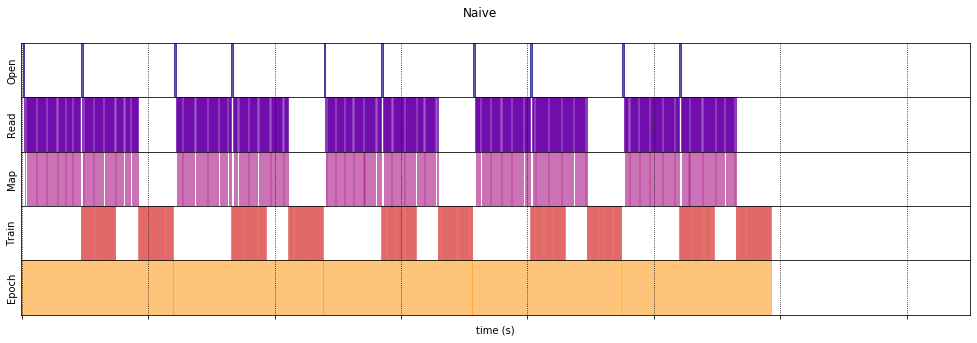

In [24]:
draw_timeline(naive_timeline, 'Naive', 15)

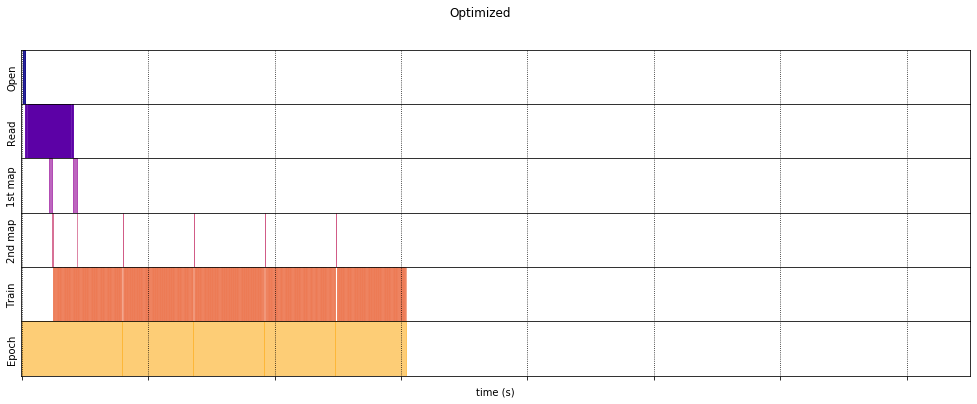

In [25]:
draw_timeline(optimized_timeline, 'Optimized', 15)